In [1]:
import pandas as pd
from datetime import datetime

def FindFuzzyNeighbors(source,target,source_column,target_column):
    from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

    import re
    def ngrams(string, n=3):
        string = re.sub(r'[,-./]|\sBD',r'', string)
        ngrams = zip(*[string[i:] for i in range(n)])
        return [''.join(ngram) for ngram in ngrams]

    from sklearn.neighbors import NearestNeighbors
    
    
    if(source.shape[0]==0):return
    if(target.shape[0]==0):return

    train = source[source_column]#.drop_duplicates() (train on source - all the names or addresses you want to check match with)
    test = target[target_column]#.drop_duplicates() (test using target)
    
    #The TF-IDF is implemented
    t_vec = TfidfVectorizer(analyzer=ngrams,use_idf=True)
    
    tfidf_vec_matrix = t_vec.fit_transform(train)
    
    #the selection of the most matched candidate is using the K-Nearest Neighbors
    nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(tfidf_vec_matrix)     

    
    def getNearestN(vectorizer, query):
        queryTFIDF_ = vectorizer.transform(query)
        t = nbrs.kneighbors(queryTFIDF_, 1, return_distance=True)
        dist_t = t[0].tolist()
        indx_t = t[1].tolist()
        return dist_t, indx_t


    import numpy as np
    dist_t, indx_t = getNearestN(t_vec, test)
      
    test_indx = 0
    
    matches =[]

    for i in range(0,len(test)):
        
        temp = [test.values[i], train.iloc[indx_t[i][0]], dist_t[i][0]
                    ,levenshtein_ratio_and_distance(test.values[i],train.iloc[indx_t[i][0]],ratio_calc=True) #if you have large dataset then this will slow down the process
               ]
            #return
        matches.append(temp)
    matches = pd.DataFrame(matches,columns=['target','source','Euclidean distance','levenshtein distance'])
    return  matches 
    
    
#calculate levenshtein distance
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])



In [2]:
# get your dataset 
source = pd.DataFrame({'s_name':['lovedeep','lovedeep abc','lovedeep xyz'],
                      's_address':['in city this and state that','from this country', 'from that country']
                      })
target = pd.DataFrame({'t_name':['lovedeep','lovedeep someone','someone as lvdeep','lovedeep xyz'],
                      't_address':['chicago illinois','newyork illinois','city state country','from this city state country']
                      })

In [3]:
source

,s_name,s_address
0,lovedeep,in city this and state that
1,lovedeep abc,from this country
2,lovedeep xyz,from that country


In [4]:
target

,t_name,t_address
0,lovedeep,chicago illinois
1,lovedeep someone,newyork illinois
2,someone as lvdeep,city state country
3,lovedeep xyz,from this city state country


In [6]:
import numpy as np
# find all the closest matches for target dataset in source dataset and return output for all of target records that could find any match in source
df = FindFuzzyNeighbors(source,target,'s_name','t_name') #save the output of name matches in dataframe
df = df.append(FindFuzzyNeighbors(source,target,'s_address','t_address')) #save maches for addresses

# print output
print(df.head(10))

                         target                       source  \
0                      lovedeep                     lovedeep   
1              lovedeep someone                     lovedeep   
2             someone as lvdeep                     lovedeep   
3                  lovedeep xyz                 lovedeep xyz   
0              chicago illinois  in city this and state that   
1              newyork illinois  in city this and state that   
2            city state country  in city this and state that   
3  from this city state country            from this country   

   Euclidean distance  levenshtein distance  
0            0.000000              1.000000  
1            0.479281              0.666667  
2            0.919402              0.480000  
3            0.000000              1.000000  
0            1.000000              0.279070  
1            1.000000              0.279070  
2            0.999652              0.533333  
3            0.768778              0.755556  


#Lets try PolyFuzz 
A python package with similar and more capability
-https://pypi.org/project/polyfuzz/

In [7]:
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz

model1 = PolyFuzz("TF-IDF").match(source['s_name'].tolist(),target['t_name'].tolist())

In [9]:
model1.get_matches()

,From,To,Similarity
0,lovedeep,lovedeep,1.000
1,lovedeep abc,lovedeep,0.746
2,lovedeep xyz,lovedeep xyz,1.000


As noticed "PolyFuzz" package saves only matched entries from two datasets. With above "FuzzyNeighbours" function, we aim to find all closest matches of "target" dataset with "source" dataset. So that we could keep track of all "target" records that what has matched and what not.  

In [10]:
import matplotlib.pyplot as plt
plt.show()

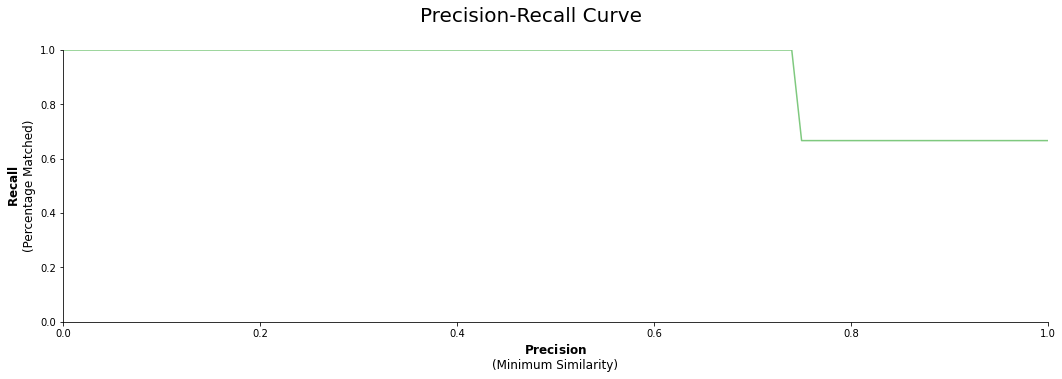

In [12]:
model1.visualize_precision_recall()